In [1]:
import tensorflow as tf
tf.__version__

#CEK GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11097553682296249100
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2634577328168598303
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6535095513
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16095886977036767262
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18233834917134877492
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from IPython import display
from numpy import asarray
from PIL import Image
from pydotplus import graphviz
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot

In [3]:
import datetime
log_dir="/Tama/logs"

summary_writer = tf.summary.create_file_writer(
  log_dir + "/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [4]:
BUFFER_SIZE = 200
BATCH_SIZE = 7
im_size = (128, 128)
im_size2 = (128,128, 3)
EPOCHS = 500
LAMBDA = 100

In [5]:
os.listdir('/Tama')

['.ipynb_checkpoints',
 '1000.JPG',
 'Checkpoints',
 'coba.jpg',
 'coba1.jpg',
 'coba2.jpg',
 'DC-GAN.ipynb',
 'dcgan-1000-3eDCGAN.png',
 'dcgan-1000-5eDCGAN.png',
 'dcgan-3000-5eDCGAN.png',
 'dcgan-full-5e.png',
 'dc_graph.png',
 'debug.log',
 'logs',
 'logsfit',
 'Old Architecture',
 'Pix2Pix.ipynb',
 'pre-d',
 'pre-n',
 'requirements.txt',
 'test-64-DCGAN.png',
 'TESTING.ipynb',
 'Train',
 'Train 1 - first experiment',
 'Train 64',
 'Train new architecture',
 'train-img']

In [6]:
day = glob.glob('pre-d/*')
night = glob.glob('pre-n/*')

In [7]:
print(len(day),'-----',len(night))

6613 ----- 6613


In [8]:
def loadImages(list_path):
    img_list = list()

    idx = 0
    for filename in list_path:
        image = Image.open(filename)
        image.thumbnail(im_size, Image.ANTIALIAS)
        pixels = np.array(image)
        print(filename)
        print(pixels.shape)
        pixels = pixels.astype('float32')
        pixels /= 255.0
        assert pixels.shape == (128, 128, 3)

        img_list.append(pixels)

        idx +=1
        print("SUCCESS -",idx)
        display.clear_output(wait=True)

    return np.array(img_list)

pixels = (pixels - 127.5) / 127.5

if using tanh should be -1,1 , search for explanation why still using [0,1]


In [9]:
data_day = []
data_night = []

In [10]:
data_day = loadImages(day)

pre-d\06613.jpg
(128, 128, 3)
SUCCESS - 6613


In [11]:
data_night = loadImages(night)

pre-n\06613.jpg
(128, 128, 3)
SUCCESS - 6613


In [13]:
train_day = tf.data.Dataset.from_tensor_slices(data_day).batch(BATCH_SIZE)

In [14]:
train_night = tf.data.Dataset.from_tensor_slices(data_night).batch(BATCH_SIZE)

In [15]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)

    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape[0], patch_shape[1], 1))
    
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model(samples)
    
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape[0], patch_shape[1], 1))
    
    return X, y

In [16]:
[X_realD, X_realN], y_real = generate_real_samples([data_day, data_night], BATCH_SIZE, [64, 64])

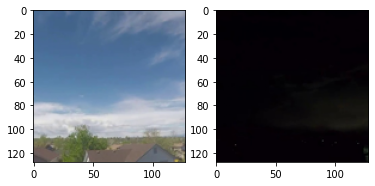

In [17]:
# PRINT SAMPLE IMAGE

f,ax = plt.subplots(1,2)
ax[0].imshow(X_realD[5])
ax[1].imshow(X_realN[5])

In [18]:
def downsample(filters, size, iStride, activation, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters,
                               size, 
                               strides=iStride, 
                               padding='same',
                                kernel_initializer=initializer, 
                               use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    if (activation == 'relu'):
        result.add(tf.keras.layers.ReLU())
    elif (activation == 'lrelu'):
        layers.LeakyReLU(alpha=0.2)

    return result

In [19]:
def upsample(filters, size, iStride, activation, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, 
                                        size, 
                                        strides=iStride,
                                        kernel_initializer=initializer,
                                        padding='same',
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    if (activation == 'relu'):
        result.add(tf.keras.layers.ReLU())
    elif (activation == 'lrelu'):
        layers.LeakyReLU(alpha=0.2)

    return result

In [20]:
def theGenerator(im_size):
    inputs = tf.keras.layers.Input(shape=im_size)

    down_stack = [
        downsample(64, 5, 1, 'lrelu'), # (bs, 128, 128, 64)
        downsample(128, 5, 1, 'lrelu'), # (bs, 128, 128, 128)
        downsample(256, 5, 2, 'lrelu'), # (bs, 64, 64, 128)
        downsample(512, 5, 2, 'lrelu'), # (bs, 32, 32, 256)
        downsample(512, 5, 2, 'lrelu'), # (bs, 16, 16, 256)
        downsample(512, 5, 2, 'lrelu'), # (bs, 8, 8, 512)
        downsample(512, 5, 1, 'lrelu'), # (bs, 4, 4, 768)
      ]

    up_stack = [
        upsample(512, 5, 1, 'relu', apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 5, 2, 'relu', apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 5, 2, 'relu'), # (bs, 16, 16, 512)
        upsample(256, 5, 2, 'relu'), # (bs, 32, 32, 256)
        upsample(128, 5, 2, 'relu'), # (bs, 64, 64, 256)
        upsample(64, 5, 1, 'relu'), # (bs, 128, 128, 128)
      ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 5,
                                         strides=1,
                                         padding='same',
                                        kernel_initializer=initializer,
                                         activation='sigmoid') # (bs, 128, 128, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
generator = theGenerator(im_size2)

In [22]:
plot_model(generator, show_shapes=True, dpi=64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [23]:
generator.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 5056        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 128, 128 205312      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 64, 256)  820224      sequential_1[0][0]               
_______________________________________________________________________________________

In [24]:
def theDiscriminator(im_size):

    def theLayer(inputLayer, 
                 nFilter, 
                 kernelSize, 
                 strideInput, 
                 batchNorm=True, 
                 dropOut=False):
        
        initializer = tf.random_normal_initializer(0., 0.02)
        model = layers.Conv2D(nFilter, 
                              kernelSize, 
                              kernel_initializer=initializer,
                              strides=strideInput, 
                              padding='same')(inputLayer)

        if (batchNorm == True):
            model = layers.BatchNormalization()(model)

        model = layers.LeakyReLU(alpha=0.2)(model)

        if (dropOut == True):
            model = layers.Dropout(0.5)(model)

        return model

    inp = layers.Input(shape=im_size, name='input_image')
    tar = layers.Input(shape=im_size, name='target_image')

    merged = layers.concatenate([inp, tar])

    d1 = theLayer(merged, 128, 5, 1)
    d2 = theLayer(d1, 256, 5, 2)
    d3 = theLayer(d2, 512, 5, 1, dropOut=True)
    d4 = theLayer(d3, 512, 5, 1, dropOut=True)
    
    model = layers.Conv2D(1, 5, 
                          strides=1, 
                          activation='sigmoid', 
                          padding='same')(d4)

    finalModel = tf.keras.Model(inputs=[inp, tar], outputs=model)

    return finalModel

In [25]:
discriminator = theDiscriminator(im_size2)

In [26]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [27]:
discriminator.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 128, 128, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 128 19328       concatenate_6[0][0]   

Search about learning rate


In [28]:
generator_optimizer = tf.keras.optimizers.Adam(lr=3e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=3e-4)

In [29]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminatorLoss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

In [31]:
def generatorLoss(fake_output, generated_output, target):
    gan_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # mean absolute error / L1
    l1_loss = tf.reduce_mean(tf.abs(target - generated_output))

    # L2
    l2_loss = tf.reduce_mean(tf.square(target - generated_output))
    
    # PSNR
    psnr_loss = tf.reduce_mean(tf.image.psnr(generated_output, target, max_val=1.0))

    l1_loss *= LAMBDA
    l2_loss *= LAMBDA

    gen_loss = gan_loss +  l1_loss + psnr_loss + l2_loss
    return gen_loss, gan_loss, l1_loss, psnr_loss, l2_loss

In [32]:
checkpoint_dir = '/Tama/Checkpoints/dcgan'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [33]:
from tensorflow.keras import metrics

generator_loss = metrics.Mean(name='generator_loss')
discriminator_loss = metrics.Mean(name='discriminator_loss')
DCGAN_loss = metrics.Mean(name='DCGAN_loss')

In [34]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(day, night, epoch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(night, training=True)

        real_output = discriminator([night, day], training=True)
        fake_output = discriminator([night, generated_image], training=True)

        gen_loss, gan_loss, l1_loss, psnr_loss, l2_loss = generatorLoss(fake_output, generated_image, day)
        disc_loss = discriminatorLoss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
    # UPDATE VARIABLE
    generator_loss(gen_loss)
    discriminator_loss(disc_loss)
    DCGAN_loss(gan_loss)

    with summary_writer.as_default():
        tf.summary.scalar('Generator_Loss', gen_loss, step=epoch)
        tf.summary.scalar('DCGAN_loss', gan_loss, step=epoch)
        tf.summary.scalar('Discriminator_Loss', disc_loss, step=epoch)
#         tf.summary.scalar('L1_Loss', l1_loss, step=epoch)
#         tf.summary.scalar('PSNR_Loss', psnr_loss, step=epoch)

In [35]:
history = {}
history['generator_loss']     = []
history['discriminator_loss'] = []
history['DCGAN_loss']      = []

In [36]:
def train(day, night, epochs):
    for epoch in range(epochs):
        start = time.time()
        idx = 0
        for imgD, imgN in tf.data.Dataset.zip((day, night)):
            train_step(imgD, imgN, epoch)
            idx+=1

        # add current loss and accuracy to history
        history['generator_loss'].append(generator_loss.result())
        history['discriminator_loss'].append(discriminator_loss.result())
        history['DCGAN_loss'].append(DCGAN_loss.result())

        # Save the Checkpoints every 10 epochs
        if (epoch + 1) % 10 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

        print ('Time for epoch {} is {} second'.format(epoch + 1, time.time()-start))
        print ('LOSS =========> Generator : {} ___ Discriminator : {} ___ DCGAN : {}'.format(generator_loss.result(),
                                                                                            discriminator_loss.result(),
                                                                                            DCGAN_loss.result()))
        
        if (epoch + 1) % 100 == 0:
            print()            
            generator.save('/Tama/Train/final/dc_generator.h5')
            discriminator.save('/Tama/Train/final/dc_discriminator.h5')
            print("Generator and Discriminator saved . . .")
        print()

In [37]:
train(train_day, train_night, EPOCHS)

Time for epoch 1 is 593.5163004398346 second
LOSS =========> Generator : 37.9387321472168 ___ Discriminator : 1.2099553346633911 ___ DCGAN : 0.6773958206176758

Time for epoch 2 is 587.383455991745 second
LOSS =========> Generator : 37.57901382446289 ___ Discriminator : 1.15498948097229 ___ DCGAN : 0.6797854900360107

Time for epoch 3 is 582.375551700592 second
LOSS =========> Generator : 37.322391510009766 ___ Discriminator : 1.1304244995117188 ___ DCGAN : 0.6819646954536438

Time for epoch 4 is 581.8800144195557 second
LOSS =========> Generator : 37.14708709716797 ___ Discriminator : 1.1193218231201172 ___ DCGAN : 0.6833888292312622

Time for epoch 5 is 581.5270719528198 second
LOSS =========> Generator : 37.010475158691406 ___ Discriminator : 1.1068629026412964 ___ DCGAN : 0.6842748522758484

Time for epoch 6 is 583.6835668087006 second
LOSS =========> Generator : 36.88951110839844 ___ Discriminator : 1.1013153791427612 ___ DCGAN : 0.6847255229949951

Time for epoch 7 is 581.7605972

Saving checkpoint for epoch 50 at /Tama/Checkpoints/dcgan\ckpt-5
Time for epoch 50 is 587.4895262718201 second
LOSS =========> Generator : 33.203826904296875 ___ Discriminator : 1.043837547302246 ___ DCGAN : 0.6859859824180603

Time for epoch 51 is 582.1270225048065 second
LOSS =========> Generator : 33.143714904785156 ___ Discriminator : 1.0432310104370117 ___ DCGAN : 0.6860716342926025

Time for epoch 52 is 582.199456691742 second
LOSS =========> Generator : 33.08422088623047 ___ Discriminator : 1.0425981283187866 ___ DCGAN : 0.6861600875854492

Time for epoch 53 is 582.176512002945 second
LOSS =========> Generator : 33.026153564453125 ___ Discriminator : 1.0420116186141968 ___ DCGAN : 0.6862396597862244

Time for epoch 54 is 581.6478435993195 second
LOSS =========> Generator : 32.96931838989258 ___ Discriminator : 1.0413986444473267 ___ DCGAN : 0.6863282918930054

Time for epoch 55 is 581.6721179485321 second
LOSS =========> Generator : 32.91319274902344 ___ Discriminator : 1.040833

Time for epoch 99 is 581.5709939002991 second
LOSS =========> Generator : 31.193897247314453 ___ Discriminator : 1.027327299118042 ___ DCGAN : 0.688266932964325

Saving checkpoint for epoch 100 at /Tama/Checkpoints/dcgan\ckpt-10
Time for epoch 100 is 588.2739105224609 second
LOSS =========> Generator : 31.165428161621094 ___ Discriminator : 1.0271321535110474 ___ DCGAN : 0.6882982850074768

Generator and Discriminator saved . . .

Time for epoch 101 is 582.0287914276123 second
LOSS =========> Generator : 31.137319564819336 ___ Discriminator : 1.026940941810608 ___ DCGAN : 0.688338577747345

Time for epoch 102 is 582.5193536281586 second
LOSS =========> Generator : 31.10967254638672 ___ Discriminator : 1.0267534255981445 ___ DCGAN : 0.6884069442749023

Time for epoch 103 is 582.5354971885681 second
LOSS =========> Generator : 31.082040786743164 ___ Discriminator : 1.0265694856643677 ___ DCGAN : 0.6884739995002747

Time for epoch 104 is 581.5498781204224 second
LOSS =========> Generator 

Time for epoch 147 is 582.2591459751129 second
LOSS =========> Generator : 30.09618377685547 ___ Discriminator : 1.0211235284805298 ___ DCGAN : 0.6902505159378052

Time for epoch 148 is 585.3680772781372 second
LOSS =========> Generator : 30.07788848876953 ___ Discriminator : 1.0209941864013672 ___ DCGAN : 0.690278947353363

Time for epoch 149 is 584.9339611530304 second
LOSS =========> Generator : 30.059906005859375 ___ Discriminator : 1.0208606719970703 ___ DCGAN : 0.6903095245361328

Saving checkpoint for epoch 150 at /Tama/Checkpoints/dcgan\ckpt-15
Time for epoch 150 is 589.8612594604492 second
LOSS =========> Generator : 30.04204559326172 ___ Discriminator : 1.020729422569275 ___ DCGAN : 0.6903411149978638

Time for epoch 151 is 584.0360858440399 second
LOSS =========> Generator : 30.024423599243164 ___ Discriminator : 1.020621418952942 ___ DCGAN : 0.6903651356697083

Time for epoch 152 is 583.4506034851074 second
LOSS =========> Generator : 30.00676727294922 ___ Discriminator : 1

Time for epoch 195 is 583.9360728263855 second
LOSS =========> Generator : 29.360485076904297 ___ Discriminator : 1.0162018537521362 ___ DCGAN : 0.6914163827896118

Time for epoch 196 is 583.4019491672516 second
LOSS =========> Generator : 29.347694396972656 ___ Discriminator : 1.0161235332489014 ___ DCGAN : 0.6914352774620056

Time for epoch 197 is 584.5088748931885 second
LOSS =========> Generator : 29.335033416748047 ___ Discriminator : 1.0160493850708008 ___ DCGAN : 0.6914536952972412

Time for epoch 198 is 582.5127773284912 second
LOSS =========> Generator : 29.32244873046875 ___ Discriminator : 1.0159738063812256 ___ DCGAN : 0.6914721727371216

Time for epoch 199 is 581.0136992931366 second
LOSS =========> Generator : 29.309951782226562 ___ Discriminator : 1.0158965587615967 ___ DCGAN : 0.6914908289909363

Saving checkpoint for epoch 200 at /Tama/Checkpoints/dcgan\ckpt-20
Time for epoch 200 is 588.0896790027618 second
LOSS =========> Generator : 29.297597885131836 ___ Discriminat

Time for epoch 243 is 583.8074035644531 second
LOSS =========> Generator : 28.8305721282959 ___ Discriminator : 1.0130751132965088 ___ DCGAN : 0.6908097863197327

Time for epoch 244 is 583.04230260849 second
LOSS =========> Generator : 28.82114028930664 ___ Discriminator : 1.013021469116211 ___ DCGAN : 0.6907962560653687

Time for epoch 245 is 583.0783531665802 second
LOSS =========> Generator : 28.81179428100586 ___ Discriminator : 1.0129684209823608 ___ DCGAN : 0.6907827854156494

Time for epoch 246 is 583.3218772411346 second
LOSS =========> Generator : 28.80248260498047 ___ Discriminator : 1.0129156112670898 ___ DCGAN : 0.6907694339752197

Time for epoch 247 is 582.9463036060333 second
LOSS =========> Generator : 28.79311752319336 ___ Discriminator : 1.0128633975982666 ___ DCGAN : 0.6907562017440796

Time for epoch 248 is 582.9006094932556 second
LOSS =========> Generator : 28.783756256103516 ___ Discriminator : 1.012811541557312 ___ DCGAN : 0.690743088722229

Time for epoch 249 is

Time for epoch 291 is 585.472939491272 second
LOSS =========> Generator : 28.428829193115234 ___ Discriminator : 1.0109361410140991 ___ DCGAN : 0.6902610063552856

Time for epoch 292 is 585.580575466156 second
LOSS =========> Generator : 28.42147445678711 ___ Discriminator : 1.0108987092971802 ___ DCGAN : 0.6902515888214111

Time for epoch 293 is 588.1854004859924 second
LOSS =========> Generator : 28.414182662963867 ___ Discriminator : 1.0108615159988403 ___ DCGAN : 0.6902421712875366

Time for epoch 294 is 585.5003607273102 second
LOSS =========> Generator : 28.406898498535156 ___ Discriminator : 1.0108245611190796 ___ DCGAN : 0.6902328133583069

Time for epoch 295 is 585.2385649681091 second
LOSS =========> Generator : 28.399717330932617 ___ Discriminator : 1.010787844657898 ___ DCGAN : 0.6902235746383667

Time for epoch 296 is 588.2725460529327 second
LOSS =========> Generator : 28.392465591430664 ___ Discriminator : 1.0107513666152954 ___ DCGAN : 0.6902143955230713

Time for epoch

Saving checkpoint for epoch 340 at /Tama/Checkpoints/dcgan\ckpt-34
Time for epoch 340 is 596.464025259018 second
LOSS =========> Generator : 28.107559204101562 ___ Discriminator : 1.0093755722045898 ___ DCGAN : 0.689860463142395

Time for epoch 341 is 589.1891648769379 second
LOSS =========> Generator : 28.10174560546875 ___ Discriminator : 1.0093532800674438 ___ DCGAN : 0.6898524761199951

Time for epoch 342 is 593.5164489746094 second
LOSS =========> Generator : 28.095918655395508 ___ Discriminator : 1.0093262195587158 ___ DCGAN : 0.689845621585846

Time for epoch 343 is 588.0604267120361 second
LOSS =========> Generator : 28.090110778808594 ___ Discriminator : 1.0092990398406982 ___ DCGAN : 0.6898387670516968

Time for epoch 344 is 586.8588635921478 second
LOSS =========> Generator : 28.084352493286133 ___ Discriminator : 1.0092719793319702 ___ DCGAN : 0.6898319721221924

Time for epoch 345 is 587.3993263244629 second
LOSS =========> Generator : 28.07866859436035 ___ Discriminator :

Time for epoch 389 is 584.1410884857178 second
LOSS =========> Generator : 27.848739624023438 ___ Discriminator : 1.0082066059112549 ___ DCGAN : 0.6895602941513062

Saving checkpoint for epoch 390 at /Tama/Checkpoints/dcgan\ckpt-39
Time for epoch 390 is 591.2391130924225 second
LOSS =========> Generator : 27.84392547607422 ___ Discriminator : 1.0081855058670044 ___ DCGAN : 0.6895549893379211

Time for epoch 391 is 585.4792809486389 second
LOSS =========> Generator : 27.83913803100586 ___ Discriminator : 1.008164644241333 ___ DCGAN : 0.6895497441291809

Time for epoch 392 is 584.2563936710358 second
LOSS =========> Generator : 27.83436393737793 ___ Discriminator : 1.008144736289978 ___ DCGAN : 0.6895444393157959

Time for epoch 393 is 585.5302925109863 second
LOSS =========> Generator : 27.829668045043945 ___ Discriminator : 1.0081239938735962 ___ DCGAN : 0.6895392537117004

Time for epoch 394 is 585.7221124172211 second
LOSS =========> Generator : 27.824951171875 ___ Discriminator : 1.

Time for epoch 437 is 593.5656695365906 second
LOSS =========> Generator : 27.636945724487305 ___ Discriminator : 1.0073174238204956 ___ DCGAN : 0.6893306374549866

Time for epoch 438 is 589.7488670349121 second
LOSS =========> Generator : 27.632898330688477 ___ Discriminator : 1.0073007345199585 ___ DCGAN : 0.6893264651298523

Time for epoch 439 is 589.535391330719 second
LOSS =========> Generator : 27.62885856628418 ___ Discriminator : 1.0072840452194214 ___ DCGAN : 0.6893223524093628

Saving checkpoint for epoch 440 at /Tama/Checkpoints/dcgan\ckpt-44
Time for epoch 440 is 598.263787984848 second
LOSS =========> Generator : 27.624839782714844 ___ Discriminator : 1.0072675943374634 ___ DCGAN : 0.6893181800842285

Time for epoch 441 is 593.1183040142059 second
LOSS =========> Generator : 27.620819091796875 ___ Discriminator : 1.0072510242462158 ___ DCGAN : 0.689314067363739

Time for epoch 442 is 592.4762749671936 second
LOSS =========> Generator : 27.616802215576172 ___ Discriminator 

Time for epoch 485 is 590.0336802005768 second
LOSS =========> Generator : 27.455734252929688 ___ Discriminator : 1.006595492362976 ___ DCGAN : 0.689149022102356

Time for epoch 486 is 591.6262845993042 second
LOSS =========> Generator : 27.45219612121582 ___ Discriminator : 1.0065820217132568 ___ DCGAN : 0.6891456246376038

Time for epoch 487 is 589.0063424110413 second
LOSS =========> Generator : 27.44866943359375 ___ Discriminator : 1.006568431854248 ___ DCGAN : 0.6891422271728516

Time for epoch 488 is 590.9558987617493 second
LOSS =========> Generator : 27.44512939453125 ___ Discriminator : 1.0065549612045288 ___ DCGAN : 0.6891388893127441

Time for epoch 489 is 588.7529582977295 second
LOSS =========> Generator : 27.441652297973633 ___ Discriminator : 1.0065416097640991 ___ DCGAN : 0.6891354918479919

Saving checkpoint for epoch 490 at /Tama/Checkpoints/dcgan\ckpt-49
Time for epoch 490 is 594.8146514892578 second
LOSS =========> Generator : 27.438175201416016 ___ Discriminator : 

In [36]:
train(train_day, train_night, EPOCHS)

Time for epoch 1 is 403.85019850730896 second
LOSS =========> Generator : 37.776466369628906 ___ Discriminator : 1.1705782413482666 ___ DCGAN : 0.6774870753288269

Time for epoch 2 is 396.59624457359314 second
LOSS =========> Generator : 37.34618377685547 ___ Discriminator : 1.143176555633545 ___ DCGAN : 0.6802978515625

Time for epoch 3 is 396.7466447353363 second
LOSS =========> Generator : 37.10408401489258 ___ Discriminator : 1.1231775283813477 ___ DCGAN : 0.6822602152824402

Time for epoch 4 is 402.0232529640198 second
LOSS =========> Generator : 36.930362701416016 ___ Discriminator : 1.1130121946334839 ___ DCGAN : 0.6832925081253052

Time for epoch 5 is 396.81750679016113 second
LOSS =========> Generator : 36.790924072265625 ___ Discriminator : 1.1065421104431152 ___ DCGAN : 0.6835750937461853

Time for epoch 6 is 396.787136554718 second
LOSS =========> Generator : 36.66606903076172 ___ Discriminator : 1.1025967597961426 ___ DCGAN : 0.6837034821510315

Time for epoch 7 is 396.905

Saving checkpoint for epoch 50 at /Tama/Checkpoints/lr/dcgan_2\ckpt-5
Time for epoch 50 is 401.53285336494446 second
LOSS =========> Generator : 33.00746536254883 ___ Discriminator : 1.052465796470642 ___ DCGAN : 0.6868671178817749

Time for epoch 51 is 396.00189900398254 second
LOSS =========> Generator : 32.950347900390625 ___ Discriminator : 1.051621437072754 ___ DCGAN : 0.6869821548461914

Time for epoch 52 is 396.66944885253906 second
LOSS =========> Generator : 32.8946533203125 ___ Discriminator : 1.0507980585098267 ___ DCGAN : 0.6870959401130676

Time for epoch 53 is 396.362676858902 second
LOSS =========> Generator : 32.83942794799805 ___ Discriminator : 1.050080418586731 ___ DCGAN : 0.6871795654296875

Time for epoch 54 is 396.2143895626068 second
LOSS =========> Generator : 32.786136627197266 ___ Discriminator : 1.0493276119232178 ___ DCGAN : 0.6872831583023071

Time for epoch 55 is 396.03734946250916 second
LOSS =========> Generator : 32.7341194152832 ___ Discriminator : 1.0

Time for epoch 99 is 396.69595670700073 second
LOSS =========> Generator : 31.121850967407227 ___ Discriminator : 1.0307528972625732 ___ DCGAN : 0.6894046664237976

Saving checkpoint for epoch 100 at /Tama/Checkpoints/lr/dcgan_2\ckpt-10
Time for epoch 100 is 402.5769417285919 second
LOSS =========> Generator : 31.094873428344727 ___ Discriminator : 1.030527114868164 ___ DCGAN : 0.6894230842590332

Generator and Discriminator saved . . .

Time for epoch 101 is 396.2126362323761 second
LOSS =========> Generator : 31.068321228027344 ___ Discriminator : 1.0303105115890503 ___ DCGAN : 0.6894404292106628

Time for epoch 102 is 396.41779708862305 second
LOSS =========> Generator : 31.041860580444336 ___ Discriminator : 1.0300922393798828 ___ DCGAN : 0.6894589066505432

Time for epoch 103 is 396.2185528278351 second
LOSS =========> Generator : 31.015817642211914 ___ Discriminator : 1.0298758745193481 ___ DCGAN : 0.689477801322937

Time for epoch 104 is 398.68587923049927 second
LOSS =========>

Time for epoch 147 is 395.7929656505585 second
LOSS =========> Generator : 30.080215454101562 ___ Discriminator : 1.0234001874923706 ___ DCGAN : 0.6901097893714905

Time for epoch 148 is 396.2197437286377 second
LOSS =========> Generator : 30.062606811523438 ___ Discriminator : 1.0233150720596313 ___ DCGAN : 0.6901381015777588

Time for epoch 149 is 396.47476863861084 second
LOSS =========> Generator : 30.04509925842285 ___ Discriminator : 1.0232117176055908 ___ DCGAN : 0.6901724338531494

Saving checkpoint for epoch 150 at /Tama/Checkpoints/lr/dcgan_2\ckpt-15
Time for epoch 150 is 402.9070153236389 second
LOSS =========> Generator : 30.02775764465332 ___ Discriminator : 1.0231093168258667 ___ DCGAN : 0.6902064681053162

Time for epoch 151 is 396.18174505233765 second
LOSS =========> Generator : 30.01072120666504 ___ Discriminator : 1.0230079889297485 ___ DCGAN : 0.690240204334259

Time for epoch 152 is 404.71141290664673 second
LOSS =========> Generator : 29.993589401245117 ___ Discri

Time for epoch 195 is 397.3139545917511 second
LOSS =========> Generator : 29.36931800842285 ___ Discriminator : 1.0197349786758423 ___ DCGAN : 0.6913105249404907

Time for epoch 196 is 398.12374687194824 second
LOSS =========> Generator : 29.356958389282227 ___ Discriminator : 1.0196343660354614 ___ DCGAN : 0.6913309097290039

Time for epoch 197 is 397.62775707244873 second
LOSS =========> Generator : 29.344642639160156 ___ Discriminator : 1.0195462703704834 ___ DCGAN : 0.6913483738899231

Time for epoch 198 is 397.41672682762146 second
LOSS =========> Generator : 29.332393646240234 ___ Discriminator : 1.0194538831710815 ___ DCGAN : 0.6913668513298035

Time for epoch 199 is 396.76474952697754 second
LOSS =========> Generator : 29.320165634155273 ___ Discriminator : 1.01935875415802 ___ DCGAN : 0.6913860440254211

Saving checkpoint for epoch 200 at /Tama/Checkpoints/lr/dcgan_2\ckpt-20
Time for epoch 200 is 402.50909519195557 second
LOSS =========> Generator : 29.308015823364258 ___ Dis

Time for epoch 243 is 400.5316050052643 second
LOSS =========> Generator : 28.848678588867188 ___ Discriminator : 1.0159422159194946 ___ DCGAN : 0.6920719146728516

Time for epoch 244 is 399.5568428039551 second
LOSS =========> Generator : 28.839393615722656 ___ Discriminator : 1.0158768892288208 ___ DCGAN : 0.6920851469039917

Time for epoch 245 is 398.724769115448 second
LOSS =========> Generator : 28.830081939697266 ___ Discriminator : 1.0158120393753052 ___ DCGAN : 0.6920983195304871

Time for epoch 246 is 398.10212898254395 second
LOSS =========> Generator : 28.820846557617188 ___ Discriminator : 1.0157477855682373 ___ DCGAN : 0.6921114325523376

Time for epoch 247 is 397.6666750907898 second
LOSS =========> Generator : 28.811614990234375 ___ Discriminator : 1.0156840085983276 ___ DCGAN : 0.6921243667602539

Time for epoch 248 is 397.66301107406616 second
LOSS =========> Generator : 28.802404403686523 ___ Discriminator : 1.0156210660934448 ___ DCGAN : 0.6921372413635254

Time for 

Time for epoch 291 is 399.12101650238037 second
LOSS =========> Generator : 28.448087692260742 ___ Discriminator : 1.0133987665176392 ___ DCGAN : 0.6924501657485962

Time for epoch 292 is 397.2646622657776 second
LOSS =========> Generator : 28.440711975097656 ___ Discriminator : 1.0133529901504517 ___ DCGAN : 0.69243323802948

Time for epoch 293 is 398.23919773101807 second
LOSS =========> Generator : 28.43332862854004 ___ Discriminator : 1.0133085250854492 ___ DCGAN : 0.6924163103103638

Time for epoch 294 is 398.74405121803284 second
LOSS =========> Generator : 28.426015853881836 ___ Discriminator : 1.013263463973999 ___ DCGAN : 0.6923995614051819

Time for epoch 295 is 466.5114314556122 second
LOSS =========> Generator : 28.418710708618164 ___ Discriminator : 1.013218641281128 ___ DCGAN : 0.6923829913139343

Time for epoch 296 is 458.6025891304016 second
LOSS =========> Generator : 28.41143226623535 ___ Discriminator : 1.013174057006836 ___ DCGAN : 0.6923664808273315

Time for epoch

Time for epoch 339 is 398.0802342891693 second
LOSS =========> Generator : 28.128877639770508 ___ Discriminator : 1.0115301609039307 ___ DCGAN : 0.6917469501495361

Saving checkpoint for epoch 340 at /Tama/Checkpoints/lr/dcgan_2\ckpt-34
Time for epoch 340 is 405.1597146987915 second
LOSS =========> Generator : 28.12293815612793 ___ Discriminator : 1.0114961862564087 ___ DCGAN : 0.6917344927787781

Time for epoch 341 is 398.7559132575989 second
LOSS =========> Generator : 28.117002487182617 ___ Discriminator : 1.0114624500274658 ___ DCGAN : 0.69172203540802

Time for epoch 342 is 404.2922556400299 second
LOSS =========> Generator : 28.111068725585938 ___ Discriminator : 1.011428952217102 ___ DCGAN : 0.6917096972465515

Time for epoch 343 is 399.31414246559143 second
LOSS =========> Generator : 28.105180740356445 ___ Discriminator : 1.0113956928253174 ___ DCGAN : 0.6916974186897278

Time for epoch 344 is 400.38519072532654 second
LOSS =========> Generator : 28.09935760498047 ___ Discrimi

Time for epoch 387 is 401.3083498477936 second
LOSS =========> Generator : 27.868343353271484 ___ Discriminator : 1.0101124048233032 ___ DCGAN : 0.6912185549736023

Time for epoch 388 is 399.7875306606293 second
LOSS =========> Generator : 27.863380432128906 ___ Discriminator : 1.0100873708724976 ___ DCGAN : 0.6912088394165039

Time for epoch 389 is 400.0554578304291 second
LOSS =========> Generator : 27.858427047729492 ___ Discriminator : 1.0100620985031128 ___ DCGAN : 0.6911993026733398

Saving checkpoint for epoch 390 at /Tama/Checkpoints/lr/dcgan_2\ckpt-39
Time for epoch 390 is 406.40319538116455 second
LOSS =========> Generator : 27.853504180908203 ___ Discriminator : 1.0100363492965698 ___ DCGAN : 0.6911898255348206

Time for epoch 391 is 403.5756506919861 second
LOSS =========> Generator : 27.848609924316406 ___ Discriminator : 1.0100107192993164 ___ DCGAN : 0.691180408000946

Time for epoch 392 is 401.75611305236816 second
LOSS =========> Generator : 27.84378433227539 ___ Discr

Time for epoch 435 is 399.3467741012573 second
LOSS =========> Generator : 27.649967193603516 ___ Discriminator : 1.00900399684906 ___ DCGAN : 0.6908072829246521

Time for epoch 436 is 399.49757504463196 second
LOSS =========> Generator : 27.645803451538086 ___ Discriminator : 1.0089833736419678 ___ DCGAN : 0.6907997131347656

Time for epoch 437 is 399.9713234901428 second
LOSS =========> Generator : 27.641603469848633 ___ Discriminator : 1.0089627504348755 ___ DCGAN : 0.6907922029495239

Time for epoch 438 is 400.00092339515686 second
LOSS =========> Generator : 27.63744354248047 ___ Discriminator : 1.0089422464370728 ___ DCGAN : 0.6907846331596375

Time for epoch 439 is 400.531400680542 second
LOSS =========> Generator : 27.6333065032959 ___ Discriminator : 1.0089219808578491 ___ DCGAN : 0.6907771825790405

Saving checkpoint for epoch 440 at /Tama/Checkpoints/lr/dcgan_2\ckpt-44
Time for epoch 440 is 405.85531091690063 second
LOSS =========> Generator : 27.629127502441406 ___ Discrimi

Time for epoch 483 is 402.02615237236023 second
LOSS =========> Generator : 27.464862823486328 ___ Discriminator : 1.0081197023391724 ___ DCGAN : 0.6904762387275696

Time for epoch 484 is 401.68761801719666 second
LOSS =========> Generator : 27.461315155029297 ___ Discriminator : 1.0081028938293457 ___ DCGAN : 0.6904700994491577

Time for epoch 485 is 401.24258041381836 second
LOSS =========> Generator : 27.457788467407227 ___ Discriminator : 1.0080862045288086 ___ DCGAN : 0.6904639601707458

Time for epoch 486 is 403.44588923454285 second
LOSS =========> Generator : 27.454269409179688 ___ Discriminator : 1.008069634437561 ___ DCGAN : 0.6904578804969788

Time for epoch 487 is 402.5358600616455 second
LOSS =========> Generator : 27.450767517089844 ___ Discriminator : 1.0080530643463135 ___ DCGAN : 0.6904518008232117

Time for epoch 488 is 402.29853081703186 second
LOSS =========> Generator : 27.447256088256836 ___ Discriminator : 1.008036494255066 ___ DCGAN : 0.6904457211494446

Time fo

In [36]:
train(train_day, train_night, EPOCHS)

Time for epoch 1 is 404.4236571788788 second
LOSS =========> Generator : 38.36479949951172 ___ Discriminator : 1.292033076286316 ___ DCGAN : 0.6730635166168213

Time for epoch 2 is 397.84465503692627 second
LOSS =========> Generator : 37.752017974853516 ___ Discriminator : 1.2573540210723877 ___ DCGAN : 0.6742197275161743

Time for epoch 3 is 398.4698007106781 second
LOSS =========> Generator : 37.448543548583984 ___ Discriminator : 1.2357503175735474 ___ DCGAN : 0.6749500632286072

Time for epoch 4 is 397.8111753463745 second
LOSS =========> Generator : 37.24111557006836 ___ Discriminator : 1.2186596393585205 ___ DCGAN : 0.6758825778961182

Time for epoch 5 is 397.3422999382019 second
LOSS =========> Generator : 37.078060150146484 ___ Discriminator : 1.2009509801864624 ___ DCGAN : 0.6763561964035034

Time for epoch 6 is 397.21566367149353 second
LOSS =========> Generator : 36.939029693603516 ___ Discriminator : 1.1858201026916504 ___ DCGAN : 0.6773912906646729

Time for epoch 7 is 399

Saving checkpoint for epoch 50 at /Tama/Checkpoints/dcgan/lr/dcgan\ckpt-5
Time for epoch 50 is 402.3506181240082 second
LOSS =========> Generator : 33.49176025390625 ___ Discriminator : 1.08613121509552 ___ DCGAN : 0.6818303465843201

Time for epoch 51 is 397.2576153278351 second
LOSS =========> Generator : 33.43149185180664 ___ Discriminator : 1.084955096244812 ___ DCGAN : 0.6819317936897278

Time for epoch 52 is 396.28108954429626 second
LOSS =========> Generator : 33.37265396118164 ___ Discriminator : 1.0839747190475464 ___ DCGAN : 0.6819820404052734

Time for epoch 53 is 396.20294308662415 second
LOSS =========> Generator : 33.314361572265625 ___ Discriminator : 1.082775592803955 ___ DCGAN : 0.6820951104164124

Time for epoch 54 is 396.6531364917755 second
LOSS =========> Generator : 33.25768280029297 ___ Discriminator : 1.0816437005996704 ___ DCGAN : 0.6822031140327454

Time for epoch 55 is 396.21846652030945 second
LOSS =========> Generator : 33.20158004760742 ___ Discriminator :

Time for epoch 98 is 396.18561482429504 second
LOSS =========> Generator : 31.457969665527344 ___ Discriminator : 1.0530927181243896 ___ DCGAN : 0.684937059879303

Time for epoch 99 is 396.466668844223 second
LOSS =========> Generator : 31.427820205688477 ___ Discriminator : 1.052695393562317 ___ DCGAN : 0.6849779486656189

Saving checkpoint for epoch 100 at /Tama/Checkpoints/dcgan/lr/dcgan\ckpt-10
Time for epoch 100 is 403.2678952217102 second
LOSS =========> Generator : 31.398082733154297 ___ Discriminator : 1.0522905588150024 ___ DCGAN : 0.6850260496139526

Generator and Discriminator saved . . .

Time for epoch 101 is 396.78355956077576 second
LOSS =========> Generator : 31.36874771118164 ___ Discriminator : 1.0518838167190552 ___ DCGAN : 0.6850729584693909

Time for epoch 102 is 397.34592032432556 second
LOSS =========> Generator : 31.339908599853516 ___ Discriminator : 1.051500678062439 ___ DCGAN : 0.6851190328598022

Time for epoch 103 is 396.7076528072357 second
LOSS =========>

Time for epoch 146 is 397.0967938899994 second
LOSS =========> Generator : 30.314546585083008 ___ Discriminator : 1.0394023656845093 ___ DCGAN : 0.6866275668144226

Time for epoch 147 is 397.30479431152344 second
LOSS =========> Generator : 30.295564651489258 ___ Discriminator : 1.0392173528671265 ___ DCGAN : 0.6866752505302429

Time for epoch 148 is 396.42230558395386 second
LOSS =========> Generator : 30.27665138244629 ___ Discriminator : 1.0390180349349976 ___ DCGAN : 0.6867274641990662

Time for epoch 149 is 396.13787484169006 second
LOSS =========> Generator : 30.258045196533203 ___ Discriminator : 1.038826584815979 ___ DCGAN : 0.6867761015892029

Saving checkpoint for epoch 150 at /Tama/Checkpoints/dcgan/lr/dcgan\ckpt-15
Time for epoch 150 is 403.288081407547 second
LOSS =========> Generator : 30.23960304260254 ___ Discriminator : 1.038636326789856 ___ DCGAN : 0.6868250966072083

Time for epoch 151 is 397.152628660202 second
LOSS =========> Generator : 30.221206665039062 ___ Disc

Time for epoch 194 is 398.28594040870667 second
LOSS =========> Generator : 29.55141830444336 ___ Discriminator : 1.0318756103515625 ___ DCGAN : 0.6886151432991028

Time for epoch 195 is 398.9052300453186 second
LOSS =========> Generator : 29.538293838500977 ___ Discriminator : 1.0317121744155884 ___ DCGAN : 0.6886495351791382

Time for epoch 196 is 398.63464736938477 second
LOSS =========> Generator : 29.52527618408203 ___ Discriminator : 1.0315502882003784 ___ DCGAN : 0.6886835098266602

Time for epoch 197 is 397.4847478866577 second
LOSS =========> Generator : 29.512191772460938 ___ Discriminator : 1.0314029455184937 ___ DCGAN : 0.6887140274047852

Time for epoch 198 is 397.36477279663086 second
LOSS =========> Generator : 29.499088287353516 ___ Discriminator : 1.0312460660934448 ___ DCGAN : 0.6887471675872803

Time for epoch 199 is 398.12665486335754 second
LOSS =========> Generator : 29.486146926879883 ___ Discriminator : 1.031089425086975 ___ DCGAN : 0.6887801289558411

Saving ch

Time for epoch 242 is 400.72404050827026 second
LOSS =========> Generator : 29.002492904663086 ___ Discriminator : 1.025618553161621 ___ DCGAN : 0.6899300813674927

Time for epoch 243 is 399.79072165489197 second
LOSS =========> Generator : 28.992752075195312 ___ Discriminator : 1.0255131721496582 ___ DCGAN : 0.6899521946907043

Time for epoch 244 is 399.50883412361145 second
LOSS =========> Generator : 28.98302459716797 ___ Discriminator : 1.0254086256027222 ___ DCGAN : 0.6899741888046265

Time for epoch 245 is 397.60148096084595 second
LOSS =========> Generator : 28.973339080810547 ___ Discriminator : 1.025304913520813 ___ DCGAN : 0.6899959444999695

Time for epoch 246 is 398.2122805118561 second
LOSS =========> Generator : 28.963668823242188 ___ Discriminator : 1.025207281112671 ___ DCGAN : 0.6900164484977722

Time for epoch 247 is 398.6552793979645 second
LOSS =========> Generator : 28.954082489013672 ___ Discriminator : 1.0251051187515259 ___ DCGAN : 0.6900378465652466

Time for e

Saving checkpoint for epoch 290 at /Tama/Checkpoints/dcgan/lr/dcgan\ckpt-29
Time for epoch 290 is 404.00705790519714 second
LOSS =========> Generator : 28.58715057373047 ___ Discriminator : 1.0214122533798218 ___ DCGAN : 0.6907225251197815

Time for epoch 291 is 397.86098074913025 second
LOSS =========> Generator : 28.579566955566406 ___ Discriminator : 1.0213429927825928 ___ DCGAN : 0.6907110810279846

Time for epoch 292 is 397.2027778625488 second
LOSS =========> Generator : 28.571971893310547 ___ Discriminator : 1.0212740898132324 ___ DCGAN : 0.6906998753547668

Time for epoch 293 is 398.4441499710083 second
LOSS =========> Generator : 28.56447982788086 ___ Discriminator : 1.0212042331695557 ___ DCGAN : 0.6906883716583252

Time for epoch 294 is 397.14945673942566 second
LOSS =========> Generator : 28.55699920654297 ___ Discriminator : 1.0211321115493774 ___ DCGAN : 0.6906775236129761

Time for epoch 295 is 452.3197042942047 second
LOSS =========> Generator : 28.549510955810547 ___ D

Time for epoch 338 is 397.52750992774963 second
LOSS =========> Generator : 28.258625030517578 ___ Discriminator : 1.0184037685394287 ___ DCGAN : 0.6902604699134827

Time for epoch 339 is 399.3819742202759 second
LOSS =========> Generator : 28.252548217773438 ___ Discriminator : 1.018349528312683 ___ DCGAN : 0.6902523040771484

Saving checkpoint for epoch 340 at /Tama/Checkpoints/dcgan/lr/dcgan\ckpt-34
Time for epoch 340 is 408.5116550922394 second
LOSS =========> Generator : 28.246530532836914 ___ Discriminator : 1.0182955265045166 ___ DCGAN : 0.6902442574501038

Time for epoch 341 is 399.0705392360687 second
LOSS =========> Generator : 28.240493774414062 ___ Discriminator : 1.0182418823242188 ___ DCGAN : 0.6902362108230591

Time for epoch 342 is 405.0272116661072 second
LOSS =========> Generator : 28.234447479248047 ___ Discriminator : 1.0181884765625 ___ DCGAN : 0.6902281641960144

Time for epoch 343 is 398.2964949607849 second
LOSS =========> Generator : 28.228487014770508 ___ Disc

Time for epoch 386 is 401.5206000804901 second
LOSS =========> Generator : 27.993234634399414 ___ Discriminator : 1.0161387920379639 ___ DCGAN : 0.6899140477180481

Time for epoch 387 is 402.1507911682129 second
LOSS =========> Generator : 27.988218307495117 ___ Discriminator : 1.016097068786621 ___ DCGAN : 0.6899077892303467

Time for epoch 388 is 403.34961557388306 second
LOSS =========> Generator : 27.983245849609375 ___ Discriminator : 1.0160555839538574 ___ DCGAN : 0.68990159034729

Time for epoch 389 is 403.5005955696106 second
LOSS =========> Generator : 27.978347778320312 ___ Discriminator : 1.0160143375396729 ___ DCGAN : 0.6898953914642334

Saving checkpoint for epoch 390 at /Tama/Checkpoints/dcgan/lr/dcgan\ckpt-39
Time for epoch 390 is 404.64764285087585 second
LOSS =========> Generator : 27.973461151123047 ___ Discriminator : 1.0159810781478882 ___ DCGAN : 0.689888596534729

Time for epoch 391 is 397.77549147605896 second
LOSS =========> Generator : 27.968618392944336 ___ Di

Time for epoch 434 is 400.48420810699463 second
LOSS =========> Generator : 27.773740768432617 ___ Discriminator : 1.014371395111084 ___ DCGAN : 0.6896445751190186

Time for epoch 435 is 400.18220114707947 second
LOSS =========> Generator : 27.769567489624023 ___ Discriminator : 1.0143382549285889 ___ DCGAN : 0.6896396279335022

Time for epoch 436 is 399.1642837524414 second
LOSS =========> Generator : 27.765426635742188 ___ Discriminator : 1.0143054723739624 ___ DCGAN : 0.6896347403526306

Time for epoch 437 is 399.6351246833801 second
LOSS =========> Generator : 27.76127052307129 ___ Discriminator : 1.014272689819336 ___ DCGAN : 0.689629852771759

Time for epoch 438 is 399.07067608833313 second
LOSS =========> Generator : 27.757144927978516 ___ Discriminator : 1.0142401456832886 ___ DCGAN : 0.6896250247955322

Time for epoch 439 is 399.65105080604553 second
LOSS =========> Generator : 27.753026962280273 ___ Discriminator : 1.0142076015472412 ___ DCGAN : 0.6896201372146606

Saving che

Time for epoch 482 is 401.8278121948242 second
LOSS =========> Generator : 27.588308334350586 ___ Discriminator : 1.0129503011703491 ___ DCGAN : 0.6894291639328003

Time for epoch 483 is 402.56569814682007 second
LOSS =========> Generator : 27.5847110748291 ___ Discriminator : 1.0129234790802002 ___ DCGAN : 0.6894251704216003

Time for epoch 484 is 402.4878544807434 second
LOSS =========> Generator : 27.581151962280273 ___ Discriminator : 1.0128967761993408 ___ DCGAN : 0.6894211769104004

Time for epoch 485 is 403.34847474098206 second
LOSS =========> Generator : 27.577646255493164 ___ Discriminator : 1.012870192527771 ___ DCGAN : 0.6894172430038452

Time for epoch 486 is 402.496018409729 second
LOSS =========> Generator : 27.574142456054688 ___ Discriminator : 1.0128436088562012 ___ DCGAN : 0.6894132494926453

Time for epoch 487 is 401.81100702285767 second
LOSS =========> Generator : 27.570655822753906 ___ Discriminator : 1.0128172636032104 ___ DCGAN : 0.6894093751907349

Time for ep

## 3000 data

In [36]:
train(train_day, train_night, EPOCHS)

Time for epoch 1 is 186.16254472732544 second
LOSS =========> Generator : 39.35667419433594 ___ Discriminator : 1.293830394744873 ___ DCGAN : 0.6712117791175842

Time for epoch 2 is 180.50772881507874 second
LOSS =========> Generator : 38.5925407409668 ___ Discriminator : 1.2330803871154785 ___ DCGAN : 0.6753100752830505

Time for epoch 3 is 180.81995058059692 second
LOSS =========> Generator : 38.14265060424805 ___ Discriminator : 1.1938962936401367 ___ DCGAN : 0.6789835691452026

Time for epoch 4 is 180.70557808876038 second
LOSS =========> Generator : 37.85589599609375 ___ Discriminator : 1.167912244796753 ___ DCGAN : 0.6812403202056885

Time for epoch 5 is 181.38798594474792 second
LOSS =========> Generator : 37.65605545043945 ___ Discriminator : 1.1501591205596924 ___ DCGAN : 0.6827048063278198

Time for epoch 6 is 181.1482093334198 second
LOSS =========> Generator : 37.499755859375 ___ Discriminator : 1.1397500038146973 ___ DCGAN : 0.6833713054656982

Time for epoch 7 is 180.7349

Saving checkpoint for epoch 50 at /Tama/Checkpoints/dcgan/lr/3000\ckpt-5
Time for epoch 50 is 186.68138146400452 second
LOSS =========> Generator : 34.091983795166016 ___ Discriminator : 1.159220814704895 ___ DCGAN : 0.6741318106651306

Time for epoch 51 is 180.25328516960144 second
LOSS =========> Generator : 34.02983856201172 ___ Discriminator : 1.157388687133789 ___ DCGAN : 0.6743326187133789

Time for epoch 52 is 180.71453428268433 second
LOSS =========> Generator : 33.9670524597168 ___ Discriminator : 1.15557062625885 ___ DCGAN : 0.6745178699493408

Time for epoch 53 is 180.5334005355835 second
LOSS =========> Generator : 33.905174255371094 ___ Discriminator : 1.153659462928772 ___ DCGAN : 0.6746792793273926

Time for epoch 54 is 180.5939667224884 second
LOSS =========> Generator : 33.84424591064453 ___ Discriminator : 1.1516118049621582 ___ DCGAN : 0.674875020980835

Time for epoch 55 is 180.16356086730957 second
LOSS =========> Generator : 33.78421401977539 ___ Discriminator : 1

Time for epoch 98 is 181.46366834640503 second
LOSS =========> Generator : 31.935537338256836 ___ Discriminator : 1.0979925394058228 ___ DCGAN : 0.6789739727973938

Time for epoch 99 is 180.69458627700806 second
LOSS =========> Generator : 31.903928756713867 ___ Discriminator : 1.0971662998199463 ___ DCGAN : 0.6790739297866821

Saving checkpoint for epoch 100 at /Tama/Checkpoints/dcgan/lr/3000\ckpt-10
Time for epoch 100 is 187.27814888954163 second
LOSS =========> Generator : 31.872648239135742 ___ Discriminator : 1.0963937044143677 ___ DCGAN : 0.6791594624519348

Generator and Discriminator saved . . .

Time for epoch 101 is 180.70458221435547 second
LOSS =========> Generator : 31.841440200805664 ___ Discriminator : 1.0956590175628662 ___ DCGAN : 0.6792386770248413

Time for epoch 102 is 180.6286175251007 second
LOSS =========> Generator : 31.81063461303711 ___ Discriminator : 1.0949277877807617 ___ DCGAN : 0.6793178915977478

Time for epoch 103 is 180.5812418460846 second
LOSS ======

Time for epoch 146 is 180.91474294662476 second
LOSS =========> Generator : 30.702930450439453 ___ Discriminator : 1.0716736316680908 ___ DCGAN : 0.6822048425674438

Time for epoch 147 is 180.9361870288849 second
LOSS =========> Generator : 30.68222427368164 ___ Discriminator : 1.0713120698928833 ___ DCGAN : 0.6822468638420105

Time for epoch 148 is 181.34782457351685 second
LOSS =========> Generator : 30.661479949951172 ___ Discriminator : 1.0709481239318848 ___ DCGAN : 0.6822927594184875

Time for epoch 149 is 180.7410352230072 second
LOSS =========> Generator : 30.64095687866211 ___ Discriminator : 1.0705705881118774 ___ DCGAN : 0.6823450326919556

Saving checkpoint for epoch 150 at /Tama/Checkpoints/dcgan/lr/3000\ckpt-15
Time for epoch 150 is 192.8606960773468 second
LOSS =========> Generator : 30.620683670043945 ___ Discriminator : 1.070195198059082 ___ DCGAN : 0.6823977828025818

Time for epoch 151 is 180.56581807136536 second
LOSS =========> Generator : 30.60066795349121 ___ Dis

Time for epoch 194 is 180.3600776195526 second
LOSS =========> Generator : 29.87152099609375 ___ Discriminator : 1.057641863822937 ___ DCGAN : 0.6838945150375366

Time for epoch 195 is 180.6850302219391 second
LOSS =========> Generator : 29.856613159179688 ___ Discriminator : 1.0574175119400024 ___ DCGAN : 0.6839227676391602

Time for epoch 196 is 180.56845378875732 second
LOSS =========> Generator : 29.842016220092773 ___ Discriminator : 1.0571825504302979 ___ DCGAN : 0.6839525699615479

Time for epoch 197 is 180.79275751113892 second
LOSS =========> Generator : 29.82750701904297 ___ Discriminator : 1.0569730997085571 ___ DCGAN : 0.6839781999588013

Time for epoch 198 is 181.0898551940918 second
LOSS =========> Generator : 29.813190460205078 ___ Discriminator : 1.056755542755127 ___ DCGAN : 0.6840028762817383

Time for epoch 199 is 180.86678647994995 second
LOSS =========> Generator : 29.79909896850586 ___ Discriminator : 1.056535005569458 ___ DCGAN : 0.684030294418335

Saving checkpo

Time for epoch 242 is 180.82222509384155 second
LOSS =========> Generator : 29.25968360900879 ___ Discriminator : 1.048568844795227 ___ DCGAN : 0.6851165890693665

Time for epoch 243 is 180.45240807533264 second
LOSS =========> Generator : 29.248727798461914 ___ Discriminator : 1.0484081506729126 ___ DCGAN : 0.6851396560668945

Time for epoch 244 is 180.65672087669373 second
LOSS =========> Generator : 29.237709045410156 ___ Discriminator : 1.0482534170150757 ___ DCGAN : 0.6851621866226196

Time for epoch 245 is 181.0387623310089 second
LOSS =========> Generator : 29.226789474487305 ___ Discriminator : 1.0480948686599731 ___ DCGAN : 0.6851853728294373

Time for epoch 246 is 181.04961276054382 second
LOSS =========> Generator : 29.21603012084961 ___ Discriminator : 1.0479341745376587 ___ DCGAN : 0.6852098107337952

Time for epoch 247 is 180.4498119354248 second
LOSS =========> Generator : 29.205341339111328 ___ Discriminator : 1.0477737188339233 ___ DCGAN : 0.6852343678474426

Time for 

Saving checkpoint for epoch 290 at /Tama/Checkpoints/dcgan/lr/3000\ckpt-29
Time for epoch 290 is 187.23931670188904 second
LOSS =========> Generator : 28.791927337646484 ___ Discriminator : 1.0426996946334839 ___ DCGAN : 0.6858206987380981

Time for epoch 291 is 180.5612347126007 second
LOSS =========> Generator : 28.783315658569336 ___ Discriminator : 1.0425844192504883 ___ DCGAN : 0.6858379244804382

Time for epoch 292 is 180.79429078102112 second
LOSS =========> Generator : 28.774721145629883 ___ Discriminator : 1.0424785614013672 ___ DCGAN : 0.685852587223053

Time for epoch 293 is 180.80710291862488 second
LOSS =========> Generator : 28.766115188598633 ___ Discriminator : 1.0423787832260132 ___ DCGAN : 0.6858653426170349

Time for epoch 294 is 189.50836157798767 second
LOSS =========> Generator : 28.757585525512695 ___ Discriminator : 1.0422829389572144 ___ DCGAN : 0.6858757734298706

Time for epoch 295 is 180.55797743797302 second
LOSS =========> Generator : 28.74908447265625 ___

Time for epoch 338 is 181.03223776817322 second
LOSS =========> Generator : 28.418542861938477 ___ Discriminator : 1.037858009338379 ___ DCGAN : 0.6868002414703369

Time for epoch 339 is 180.7878975868225 second
LOSS =========> Generator : 28.411577224731445 ___ Discriminator : 1.0377693176269531 ___ DCGAN : 0.6868253946304321

Saving checkpoint for epoch 340 at /Tama/Checkpoints/dcgan/lr/3000\ckpt-34
Time for epoch 340 is 186.40486121177673 second
LOSS =========> Generator : 28.404653549194336 ___ Discriminator : 1.037681221961975 ___ DCGAN : 0.6868503093719482

Time for epoch 341 is 181.23442792892456 second
LOSS =========> Generator : 28.39777374267578 ___ Discriminator : 1.0375936031341553 ___ DCGAN : 0.6868751645088196

Time for epoch 342 is 182.61662220954895 second
LOSS =========> Generator : 28.39095115661621 ___ Discriminator : 1.0375065803527832 ___ DCGAN : 0.6868998408317566

Time for epoch 343 is 180.8864288330078 second
LOSS =========> Generator : 28.38408660888672 ___ Dis

Time for epoch 386 is 181.04450821876526 second
LOSS =========> Generator : 28.11261749267578 ___ Discriminator : 1.0341664552688599 ___ DCGAN : 0.6878443360328674

Time for epoch 387 is 180.90310192108154 second
LOSS =========> Generator : 28.106868743896484 ___ Discriminator : 1.0340982675552368 ___ DCGAN : 0.6878636479377747

Time for epoch 388 is 180.77635860443115 second
LOSS =========> Generator : 28.101076126098633 ___ Discriminator : 1.034030556678772 ___ DCGAN : 0.6878828406333923

Time for epoch 389 is 180.8002152442932 second
LOSS =========> Generator : 28.095335006713867 ___ Discriminator : 1.0339632034301758 ___ DCGAN : 0.6879019141197205

Saving checkpoint for epoch 390 at /Tama/Checkpoints/dcgan/lr/3000\ckpt-39
Time for epoch 390 is 187.27256321907043 second
LOSS =========> Generator : 28.089656829833984 ___ Discriminator : 1.033914566040039 ___ DCGAN : 0.6879145503044128

Time for epoch 391 is 180.3195025920868 second
LOSS =========> Generator : 28.084009170532227 ___ D

Time for epoch 434 is 181.20847487449646 second
LOSS =========> Generator : 27.8591365814209 ___ Discriminator : 1.0310989618301392 ___ DCGAN : 0.6886574029922485

Time for epoch 435 is 181.80307030677795 second
LOSS =========> Generator : 27.854230880737305 ___ Discriminator : 1.0310274362564087 ___ DCGAN : 0.6886727213859558

Time for epoch 436 is 181.43018984794617 second
LOSS =========> Generator : 27.849342346191406 ___ Discriminator : 1.0309562683105469 ___ DCGAN : 0.6886879205703735

Time for epoch 437 is 180.9381034374237 second
LOSS =========> Generator : 27.84444808959961 ___ Discriminator : 1.0308854579925537 ___ DCGAN : 0.6887031197547913

Time for epoch 438 is 181.1511104106903 second
LOSS =========> Generator : 27.839603424072266 ___ Discriminator : 1.0308148860931396 ___ DCGAN : 0.6887181997299194

Time for epoch 439 is 181.97771883010864 second
LOSS =========> Generator : 27.834808349609375 ___ Discriminator : 1.0307446718215942 ___ DCGAN : 0.6887332201004028

Saving ch

Time for epoch 482 is 180.81647086143494 second
LOSS =========> Generator : 27.642820358276367 ___ Discriminator : 1.028037428855896 ___ DCGAN : 0.6893109083175659

Time for epoch 483 is 180.72141528129578 second
LOSS =========> Generator : 27.638607025146484 ___ Discriminator : 1.0279793739318848 ___ DCGAN : 0.689323365688324

Time for epoch 484 is 180.70719480514526 second
LOSS =========> Generator : 27.634441375732422 ___ Discriminator : 1.0279327630996704 ___ DCGAN : 0.6893327832221985

Time for epoch 485 is 180.65345859527588 second
LOSS =========> Generator : 27.63031005859375 ___ Discriminator : 1.0278815031051636 ___ DCGAN : 0.6893436312675476

Time for epoch 486 is 181.16969466209412 second
LOSS =========> Generator : 27.626224517822266 ___ Discriminator : 1.0278241634368896 ___ DCGAN : 0.6893559098243713

Time for epoch 487 is 180.7630054950714 second
LOSS =========> Generator : 27.622236251831055 ___ Discriminator : 1.0277670621871948 ___ DCGAN : 0.6893681287765503

Time for

## 1000 Data

### 3e

In [36]:
train(train_day, train_night, EPOCHS)

Time for epoch 1 is 66.52354764938354 second
LOSS =========> Generator : 41.118927001953125 ___ Discriminator : 1.310461401939392 ___ DCGAN : 0.6692038774490356

Time for epoch 2 is 60.85162162780762 second
LOSS =========> Generator : 40.12016296386719 ___ Discriminator : 1.314846396446228 ___ DCGAN : 0.6676272749900818

Time for epoch 3 is 60.945310831069946 second
LOSS =========> Generator : 39.645206451416016 ___ Discriminator : 1.3109132051467896 ___ DCGAN : 0.6681972146034241

Time for epoch 4 is 61.072519063949585 second
LOSS =========> Generator : 39.281646728515625 ___ Discriminator : 1.3105491399765015 ___ DCGAN : 0.6678354740142822

Time for epoch 5 is 61.13051724433899 second
LOSS =========> Generator : 39.03124237060547 ___ Discriminator : 1.308200478553772 ___ DCGAN : 0.6688417792320251

Time for epoch 6 is 61.46252107620239 second
LOSS =========> Generator : 38.828922271728516 ___ Discriminator : 1.3070834875106812 ___ DCGAN : 0.6703559756278992

Time for epoch 7 is 61.14

Saving checkpoint for epoch 50 at /Tama/Checkpoints/dcgan/lr/1000_3\ckpt-5
Time for epoch 50 is 67.45524215698242 second
LOSS =========> Generator : 34.90224838256836 ___ Discriminator : 1.2336379289627075 ___ DCGAN : 0.6715521812438965

Time for epoch 51 is 60.89546298980713 second
LOSS =========> Generator : 34.834449768066406 ___ Discriminator : 1.2307792901992798 ___ DCGAN : 0.6718834042549133

Time for epoch 52 is 61.00642418861389 second
LOSS =========> Generator : 34.767662048339844 ___ Discriminator : 1.2279243469238281 ___ DCGAN : 0.6722280383110046

Time for epoch 53 is 61.0109760761261 second
LOSS =========> Generator : 34.70140838623047 ___ Discriminator : 1.2253737449645996 ___ DCGAN : 0.6725080609321594

Time for epoch 54 is 61.34057950973511 second
LOSS =========> Generator : 34.637569427490234 ___ Discriminator : 1.223199725151062 ___ DCGAN : 0.672709584236145

Time for epoch 55 is 61.07356405258179 second
LOSS =========> Generator : 34.5799674987793 ___ Discriminator :

Time for epoch 98 is 61.2641065120697 second
LOSS =========> Generator : 32.521888732910156 ___ Discriminator : 1.1507121324539185 ___ DCGAN : 0.6802931427955627

Time for epoch 99 is 60.905425786972046 second
LOSS =========> Generator : 32.48923110961914 ___ Discriminator : 1.1495639085769653 ___ DCGAN : 0.6804149150848389

Saving checkpoint for epoch 100 at /Tama/Checkpoints/dcgan/lr/1000_3\ckpt-10
Time for epoch 100 is 67.34505867958069 second
LOSS =========> Generator : 32.456520080566406 ___ Discriminator : 1.1485170125961304 ___ DCGAN : 0.6805208921432495

Generator and Discriminator saved . . .

Time for epoch 101 is 61.43533492088318 second
LOSS =========> Generator : 32.42465591430664 ___ Discriminator : 1.147391438484192 ___ DCGAN : 0.6806417107582092

Time for epoch 102 is 60.963438510894775 second
LOSS =========> Generator : 32.39334487915039 ___ Discriminator : 1.1462788581848145 ___ DCGAN : 0.6807538866996765

Time for epoch 103 is 61.06506896018982 second
LOSS =========>

Time for epoch 146 is 61.13416075706482 second
LOSS =========> Generator : 31.30069923400879 ___ Discriminator : 1.122748851776123 ___ DCGAN : 0.6829593181610107

Time for epoch 147 is 61.24033737182617 second
LOSS =========> Generator : 31.2805118560791 ___ Discriminator : 1.123021125793457 ___ DCGAN : 0.6828908920288086

Time for epoch 148 is 60.89112687110901 second
LOSS =========> Generator : 31.2602596282959 ___ Discriminator : 1.123210072517395 ___ DCGAN : 0.6828188300132751

Time for epoch 149 is 60.97299861907959 second
LOSS =========> Generator : 31.239877700805664 ___ Discriminator : 1.1236799955368042 ___ DCGAN : 0.6827130317687988

Saving checkpoint for epoch 150 at /Tama/Checkpoints/dcgan/lr/1000_3\ckpt-15
Time for epoch 150 is 66.51807022094727 second
LOSS =========> Generator : 31.22052001953125 ___ Discriminator : 1.1243034601211548 ___ DCGAN : 0.6826003193855286

Time for epoch 151 is 65.67706036567688 second
LOSS =========> Generator : 31.201955795288086 ___ Discrimin

Time for epoch 194 is 60.984254360198975 second
LOSS =========> Generator : 30.500167846679688 ___ Discriminator : 1.1205843687057495 ___ DCGAN : 0.6800568103790283

Time for epoch 195 is 60.95833921432495 second
LOSS =========> Generator : 30.485990524291992 ___ Discriminator : 1.12013578414917 ___ DCGAN : 0.6800695061683655

Time for epoch 196 is 61.00640106201172 second
LOSS =========> Generator : 30.472166061401367 ___ Discriminator : 1.1197348833084106 ___ DCGAN : 0.6800559759140015

Time for epoch 197 is 61.145572900772095 second
LOSS =========> Generator : 30.457935333251953 ___ Discriminator : 1.1194220781326294 ___ DCGAN : 0.6800153851509094

Time for epoch 198 is 60.875455141067505 second
LOSS =========> Generator : 30.443925857543945 ___ Discriminator : 1.1189929246902466 ___ DCGAN : 0.6800289154052734

Time for epoch 199 is 60.776631116867065 second
LOSS =========> Generator : 30.42927360534668 ___ Discriminator : 1.1185321807861328 ___ DCGAN : 0.6800600290298462

Saving ch

Time for epoch 242 is 60.974085330963135 second
LOSS =========> Generator : 29.88204574584961 ___ Discriminator : 1.1046741008758545 ___ DCGAN : 0.6799090504646301

Time for epoch 243 is 60.90454578399658 second
LOSS =========> Generator : 29.870344161987305 ___ Discriminator : 1.1043975353240967 ___ DCGAN : 0.679913341999054

Time for epoch 244 is 61.03949809074402 second
LOSS =========> Generator : 29.85893440246582 ___ Discriminator : 1.1041016578674316 ___ DCGAN : 0.6799212098121643

Time for epoch 245 is 60.832927227020264 second
LOSS =========> Generator : 29.84752082824707 ___ Discriminator : 1.1038622856140137 ___ DCGAN : 0.6799218654632568

Time for epoch 246 is 61.196600675582886 second
LOSS =========> Generator : 29.836471557617188 ___ Discriminator : 1.103639006614685 ___ DCGAN : 0.6799012422561646

Time for epoch 247 is 61.04488968849182 second
LOSS =========> Generator : 29.825809478759766 ___ Discriminator : 1.1033780574798584 ___ DCGAN : 0.6798941493034363

Time for epo

Saving checkpoint for epoch 290 at /Tama/Checkpoints/dcgan/lr/1000_3\ckpt-29
Time for epoch 290 is 66.96630311012268 second
LOSS =========> Generator : 29.393630981445312 ___ Discriminator : 1.0928833484649658 ___ DCGAN : 0.680239200592041

Time for epoch 291 is 61.07130312919617 second
LOSS =========> Generator : 29.384464263916016 ___ Discriminator : 1.0926393270492554 ___ DCGAN : 0.6802594661712646

Time for epoch 292 is 61.10837268829346 second
LOSS =========> Generator : 29.37542724609375 ___ Discriminator : 1.0924077033996582 ___ DCGAN : 0.6802790760993958

Time for epoch 293 is 61.192110776901245 second
LOSS =========> Generator : 29.36644744873047 ___ Discriminator : 1.092193603515625 ___ DCGAN : 0.6802905797958374

Time for epoch 294 is 60.942020416259766 second
LOSS =========> Generator : 29.3575439453125 ___ Discriminator : 1.091957688331604 ___ DCGAN : 0.6803081035614014

Time for epoch 295 is 60.87550091743469 second
LOSS =========> Generator : 29.34880256652832 ___ Discri

Time for epoch 338 is 61.2481255531311 second
LOSS =========> Generator : 28.994997024536133 ___ Discriminator : 1.0822826623916626 ___ DCGAN : 0.6814285516738892

Time for epoch 339 is 61.05905270576477 second
LOSS =========> Generator : 28.98727035522461 ___ Discriminator : 1.0820708274841309 ___ DCGAN : 0.6814596056938171

Saving checkpoint for epoch 340 at /Tama/Checkpoints/dcgan/lr/1000_3\ckpt-34
Time for epoch 340 is 66.69387125968933 second
LOSS =========> Generator : 28.979557037353516 ___ Discriminator : 1.0818594694137573 ___ DCGAN : 0.6814911365509033

Time for epoch 341 is 61.47696876525879 second
LOSS =========> Generator : 28.972070693969727 ___ Discriminator : 1.0816481113433838 ___ DCGAN : 0.6815240383148193

Time for epoch 342 is 61.0731840133667 second
LOSS =========> Generator : 28.964784622192383 ___ Discriminator : 1.0814327001571655 ___ DCGAN : 0.6815582513809204

Time for epoch 343 is 60.954395055770874 second
LOSS =========> Generator : 28.957534790039062 ___ Di

Time for epoch 386 is 61.29777407646179 second
LOSS =========> Generator : 28.66280174255371 ___ Discriminator : 1.0730443000793457 ___ DCGAN : 0.6829013824462891

Time for epoch 387 is 60.9463894367218 second
LOSS =========> Generator : 28.656476974487305 ___ Discriminator : 1.072875738143921 ___ DCGAN : 0.6829284429550171

Time for epoch 388 is 61.17820978164673 second
LOSS =========> Generator : 28.650102615356445 ___ Discriminator : 1.0727081298828125 ___ DCGAN : 0.6829553246498108

Time for epoch 389 is 61.12095904350281 second
LOSS =========> Generator : 28.643625259399414 ___ Discriminator : 1.0725412368774414 ___ DCGAN : 0.6829820275306702

Saving checkpoint for epoch 390 at /Tama/Checkpoints/dcgan/lr/1000_3\ckpt-39
Time for epoch 390 is 67.22183680534363 second
LOSS =========> Generator : 28.637149810791016 ___ Discriminator : 1.0723752975463867 ___ DCGAN : 0.6830086708068848

Time for epoch 391 is 61.19724249839783 second
LOSS =========> Generator : 28.630661010742188 ___ Dis

Time for epoch 434 is 61.34390902519226 second
LOSS =========> Generator : 28.375972747802734 ___ Discriminator : 1.0662422180175781 ___ DCGAN : 0.6839308142662048

Time for epoch 435 is 61.035998821258545 second
LOSS =========> Generator : 28.370439529418945 ___ Discriminator : 1.0661078691482544 ___ DCGAN : 0.6839525103569031

Time for epoch 436 is 61.3128445148468 second
LOSS =========> Generator : 28.365015029907227 ___ Discriminator : 1.0659741163253784 ___ DCGAN : 0.6839740872383118

Time for epoch 437 is 61.18457508087158 second
LOSS =========> Generator : 28.359634399414062 ___ Discriminator : 1.0658410787582397 ___ DCGAN : 0.6839955449104309

Time for epoch 438 is 61.08281636238098 second
LOSS =========> Generator : 28.354297637939453 ___ Discriminator : 1.0657085180282593 ___ DCGAN : 0.6840169429779053

Time for epoch 439 is 60.878695487976074 second
LOSS =========> Generator : 28.349082946777344 ___ Discriminator : 1.0655766725540161 ___ DCGAN : 0.6840382218360901

Saving ch

Time for epoch 482 is 61.29856729507446 second
LOSS =========> Generator : 28.129056930541992 ___ Discriminator : 1.060423493385315 ___ DCGAN : 0.684855580329895

Time for epoch 483 is 61.2018301486969 second
LOSS =========> Generator : 28.124542236328125 ___ Discriminator : 1.0603145360946655 ___ DCGAN : 0.6848691701889038

Time for epoch 484 is 61.43286156654358 second
LOSS =========> Generator : 28.12001609802246 ___ Discriminator : 1.0602060556411743 ___ DCGAN : 0.684882640838623

Time for epoch 485 is 61.069278955459595 second
LOSS =========> Generator : 28.115522384643555 ___ Discriminator : 1.0600980520248413 ___ DCGAN : 0.6848961114883423

Time for epoch 486 is 61.21090340614319 second
LOSS =========> Generator : 28.110904693603516 ___ Discriminator : 1.059990406036377 ___ DCGAN : 0.6849095225334167

Time for epoch 487 is 61.3085560798645 second
LOSS =========> Generator : 28.10626983642578 ___ Discriminator : 1.0598832368850708 ___ DCGAN : 0.6849228143692017

Time for epoch 48

### 5e

In [36]:
train(train_day, train_night, EPOCHS)

Time for epoch 1 is 65.90781044960022 second
LOSS =========> Generator : 41.40103530883789 ___ Discriminator : 1.356590986251831 ___ DCGAN : 0.6665163636207581

Time for epoch 2 is 60.145527362823486 second
LOSS =========> Generator : 40.45206069946289 ___ Discriminator : 1.3533233404159546 ___ DCGAN : 0.6671693921089172

Time for epoch 3 is 60.62420654296875 second
LOSS =========> Generator : 39.95846176147461 ___ Discriminator : 1.3368717432022095 ___ DCGAN : 0.6665960550308228

Time for epoch 4 is 60.48150944709778 second
LOSS =========> Generator : 39.574546813964844 ___ Discriminator : 1.3186947107315063 ___ DCGAN : 0.6668757796287537

Time for epoch 5 is 60.78962159156799 second
LOSS =========> Generator : 39.2762336730957 ___ Discriminator : 1.303632378578186 ___ DCGAN : 0.6678096652030945

Time for epoch 6 is 60.879544496536255 second
LOSS =========> Generator : 39.03427505493164 ___ Discriminator : 1.293628215789795 ___ DCGAN : 0.6679637432098389

Time for epoch 7 is 61.484570

Saving checkpoint for epoch 50 at /Tama/Checkpoints/dcgan/lr/1000\ckpt-5
Time for epoch 50 is 67.60492277145386 second
LOSS =========> Generator : 35.13169479370117 ___ Discriminator : 1.2561129331588745 ___ DCGAN : 0.6620504260063171

Time for epoch 51 is 60.69189643859863 second
LOSS =========> Generator : 35.06198501586914 ___ Discriminator : 1.2573199272155762 ___ DCGAN : 0.6619038581848145

Time for epoch 52 is 60.945597410202026 second
LOSS =========> Generator : 34.99251937866211 ___ Discriminator : 1.2579196691513062 ___ DCGAN : 0.66168212890625

Time for epoch 53 is 60.7673978805542 second
LOSS =========> Generator : 34.92342758178711 ___ Discriminator : 1.2580335140228271 ___ DCGAN : 0.6616389751434326

Time for epoch 54 is 60.7246949672699 second
LOSS =========> Generator : 34.85972213745117 ___ Discriminator : 1.2584377527236938 ___ DCGAN : 0.6615726947784424

Time for epoch 55 is 60.94640398025513 second
LOSS =========> Generator : 34.79658126831055 ___ Discriminator : 1.2

Time for epoch 99 is 60.996490478515625 second
LOSS =========> Generator : 32.70811462402344 ___ Discriminator : 1.2410871982574463 ___ DCGAN : 0.6629246473312378

Saving checkpoint for epoch 100 at /Tama/Checkpoints/dcgan/lr/1000\ckpt-10
Time for epoch 100 is 66.74341821670532 second
LOSS =========> Generator : 32.67654800415039 ___ Discriminator : 1.240356683731079 ___ DCGAN : 0.6629835367202759

Generator and Discriminator saved . . .

Time for epoch 101 is 61.108699321746826 second
LOSS =========> Generator : 32.646244049072266 ___ Discriminator : 1.2394683361053467 ___ DCGAN : 0.663083016872406

Time for epoch 102 is 60.77446532249451 second
LOSS =========> Generator : 32.61616516113281 ___ Discriminator : 1.238660454750061 ___ DCGAN : 0.6631662845611572

Time for epoch 103 is 60.85717058181763 second
LOSS =========> Generator : 32.58527755737305 ___ Discriminator : 1.2379206418991089 ___ DCGAN : 0.6632319688796997

Time for epoch 104 is 60.79834318161011 second
LOSS =========> Ge

Time for epoch 147 is 60.98650074005127 second
LOSS =========> Generator : 31.437776565551758 ___ Discriminator : 1.1916323900222778 ___ DCGAN : 0.6674765944480896

Time for epoch 148 is 60.732949018478394 second
LOSS =========> Generator : 31.416950225830078 ___ Discriminator : 1.1906489133834839 ___ DCGAN : 0.6675555109977722

Time for epoch 149 is 61.182201862335205 second
LOSS =========> Generator : 31.395734786987305 ___ Discriminator : 1.1895421743392944 ___ DCGAN : 0.6676760911941528

Saving checkpoint for epoch 150 at /Tama/Checkpoints/dcgan/lr/1000\ckpt-15
Time for epoch 150 is 71.66248869895935 second
LOSS =========> Generator : 31.37487030029297 ___ Discriminator : 1.1884509325027466 ___ DCGAN : 0.6677910089492798

Time for epoch 151 is 60.61727285385132 second
LOSS =========> Generator : 31.35434341430664 ___ Discriminator : 1.1873773336410522 ___ DCGAN : 0.6679039001464844

Time for epoch 152 is 60.63483738899231 second
LOSS =========> Generator : 31.334867477416992 ___ Di

Time for epoch 195 is 60.7260308265686 second
LOSS =========> Generator : 30.57748031616211 ___ Discriminator : 1.1515393257141113 ___ DCGAN : 0.6715905666351318

Time for epoch 196 is 60.70504307746887 second
LOSS =========> Generator : 30.56190299987793 ___ Discriminator : 1.1508758068084717 ___ DCGAN : 0.6716693043708801

Time for epoch 197 is 60.8295476436615 second
LOSS =========> Generator : 30.54623794555664 ___ Discriminator : 1.1502331495285034 ___ DCGAN : 0.6717413663864136

Time for epoch 198 is 60.967028856277466 second
LOSS =========> Generator : 30.530391693115234 ___ Discriminator : 1.1496182680130005 ___ DCGAN : 0.6718005537986755

Time for epoch 199 is 60.789270639419556 second
LOSS =========> Generator : 30.514570236206055 ___ Discriminator : 1.1490660905838013 ___ DCGAN : 0.6718546152114868

Saving checkpoint for epoch 200 at /Tama/Checkpoints/dcgan/lr/1000\ckpt-20
Time for epoch 200 is 66.89569139480591 second
LOSS =========> Generator : 30.49915313720703 ___ Discri

Time for epoch 243 is 60.61656451225281 second
LOSS =========> Generator : 29.926944732666016 ___ Discriminator : 1.1258764266967773 ___ DCGAN : 0.6746101975440979

Time for epoch 244 is 60.67359375953674 second
LOSS =========> Generator : 29.915555953979492 ___ Discriminator : 1.1254128217697144 ___ DCGAN : 0.6746781468391418

Time for epoch 245 is 60.785454988479614 second
LOSS =========> Generator : 29.90448760986328 ___ Discriminator : 1.1249847412109375 ___ DCGAN : 0.674729585647583

Time for epoch 246 is 60.839200019836426 second
LOSS =========> Generator : 29.893404006958008 ___ Discriminator : 1.1246459484100342 ___ DCGAN : 0.6747475266456604

Time for epoch 247 is 61.088375091552734 second
LOSS =========> Generator : 29.882221221923828 ___ Discriminator : 1.1242448091506958 ___ DCGAN : 0.6747916340827942

Time for epoch 248 is 60.746392250061035 second
LOSS =========> Generator : 29.870628356933594 ___ Discriminator : 1.1238127946853638 ___ DCGAN : 0.6748496294021606

Time for

Time for epoch 291 is 61.13324213027954 second
LOSS =========> Generator : 29.421743392944336 ___ Discriminator : 1.1081821918487549 ___ DCGAN : 0.676853597164154

Time for epoch 292 is 61.05491924285889 second
LOSS =========> Generator : 29.412431716918945 ___ Discriminator : 1.107865333557129 ___ DCGAN : 0.6768971681594849

Time for epoch 293 is 60.83086156845093 second
LOSS =========> Generator : 29.403060913085938 ___ Discriminator : 1.1075464487075806 ___ DCGAN : 0.6769416332244873

Time for epoch 294 is 69.48367714881897 second
LOSS =========> Generator : 29.393632888793945 ___ Discriminator : 1.1072344779968262 ___ DCGAN : 0.676982581615448

Time for epoch 295 is 60.963873624801636 second
LOSS =========> Generator : 29.384281158447266 ___ Discriminator : 1.1069614887237549 ___ DCGAN : 0.677012026309967

Time for epoch 296 is 60.64592003822327 second
LOSS =========> Generator : 29.374780654907227 ___ Discriminator : 1.1066826581954956 ___ DCGAN : 0.6770385503768921

Time for epoc

Time for epoch 339 is 60.684661865234375 second
LOSS =========> Generator : 29.010988235473633 ___ Discriminator : 1.095414400100708 ___ DCGAN : 0.6785856485366821

Saving checkpoint for epoch 340 at /Tama/Checkpoints/dcgan/lr/1000\ckpt-34
Time for epoch 340 is 66.40618371963501 second
LOSS =========> Generator : 29.003435134887695 ___ Discriminator : 1.0951743125915527 ___ DCGAN : 0.6786220669746399

Time for epoch 341 is 60.63395142555237 second
LOSS =========> Generator : 28.996042251586914 ___ Discriminator : 1.0949312448501587 ___ DCGAN : 0.6786583065986633

Time for epoch 342 is 61.06886410713196 second
LOSS =========> Generator : 28.98849868774414 ___ Discriminator : 1.0946835279464722 ___ DCGAN : 0.6786994934082031

Time for epoch 343 is 60.76549196243286 second
LOSS =========> Generator : 28.981002807617188 ___ Discriminator : 1.0944370031356812 ___ DCGAN : 0.6787395477294922

Time for epoch 344 is 60.96031737327576 second
LOSS =========> Generator : 28.97341537475586 ___ Disc

Time for epoch 387 is 60.71058177947998 second
LOSS =========> Generator : 28.6678524017334 ___ Discriminator : 1.0853153467178345 ___ DCGAN : 0.6801269054412842

Time for epoch 388 is 60.68771004676819 second
LOSS =========> Generator : 28.661352157592773 ___ Discriminator : 1.0851155519485474 ___ DCGAN : 0.6801609992980957

Time for epoch 389 is 60.65696167945862 second
LOSS =========> Generator : 28.654903411865234 ___ Discriminator : 1.0849168300628662 ___ DCGAN : 0.6801949143409729

Saving checkpoint for epoch 390 at /Tama/Checkpoints/dcgan/lr/1000\ckpt-39
Time for epoch 390 is 67.26655721664429 second
LOSS =========> Generator : 28.648439407348633 ___ Discriminator : 1.084719181060791 ___ DCGAN : 0.6802286505699158

Time for epoch 391 is 61.02454686164856 second
LOSS =========> Generator : 28.642017364501953 ___ Discriminator : 1.0845224857330322 ___ DCGAN : 0.6802622675895691

Time for epoch 392 is 60.898048639297485 second
LOSS =========> Generator : 28.63556480407715 ___ Discr

Time for epoch 435 is 60.76800489425659 second
LOSS =========> Generator : 28.374670028686523 ___ Discriminator : 1.0781980752944946 ___ DCGAN : 0.6811389327049255

Time for epoch 436 is 60.852946281433105 second
LOSS =========> Generator : 28.368915557861328 ___ Discriminator : 1.078059434890747 ___ DCGAN : 0.681157648563385

Time for epoch 437 is 61.058295488357544 second
LOSS =========> Generator : 28.363237380981445 ___ Discriminator : 1.07792329788208 ___ DCGAN : 0.6811726689338684

Time for epoch 438 is 60.78648638725281 second
LOSS =========> Generator : 28.357593536376953 ___ Discriminator : 1.0777838230133057 ___ DCGAN : 0.6811903119087219

Time for epoch 439 is 60.62459444999695 second
LOSS =========> Generator : 28.352046966552734 ___ Discriminator : 1.077635407447815 ___ DCGAN : 0.6812126040458679

Saving checkpoint for epoch 440 at /Tama/Checkpoints/dcgan/lr/1000\ckpt-44
Time for epoch 440 is 66.9777581691742 second
LOSS =========> Generator : 28.34644889831543 ___ Discrim

Time for epoch 483 is 60.892385482788086 second
LOSS =========> Generator : 28.12247657775879 ___ Discriminator : 1.0715831518173218 ___ DCGAN : 0.6821757555007935

Time for epoch 484 is 60.95092439651489 second
LOSS =========> Generator : 28.117639541625977 ___ Discriminator : 1.0714513063430786 ___ DCGAN : 0.6821948289871216

Time for epoch 485 is 61.156489849090576 second
LOSS =========> Generator : 28.11278533935547 ___ Discriminator : 1.0713201761245728 ___ DCGAN : 0.6822138428688049

Time for epoch 486 is 61.053430795669556 second
LOSS =========> Generator : 28.107885360717773 ___ Discriminator : 1.071189522743225 ___ DCGAN : 0.6822327375411987

Time for epoch 487 is 60.91182565689087 second
LOSS =========> Generator : 28.102956771850586 ___ Discriminator : 1.0710593461990356 ___ DCGAN : 0.6822515726089478

Time for epoch 488 is 61.108630418777466 second
LOSS =========> Generator : 28.097949981689453 ___ Discriminator : 1.070929765701294 ___ DCGAN : 0.682270348072052

Time for ep

In [5]:
%load_ext tensorboard
%tensorboard --logdir {"/Tama/logsfit/dcgan"} --host localhost

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4568), started 1:12:27 ago. (Use '!kill 4568' to kill it.)

In [51]:
!kill 3032

kill: 3032: No such process


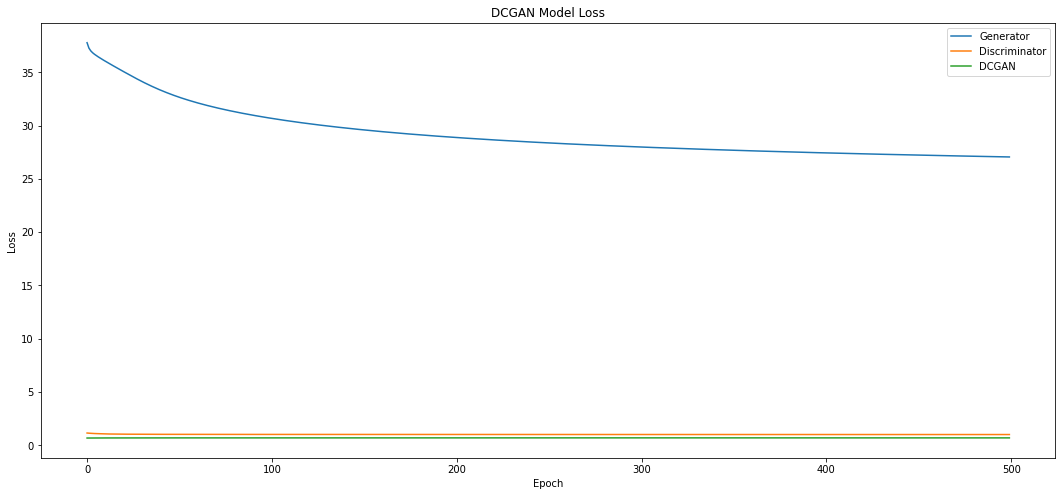

In [38]:
plt.rcParams['figure.figsize'] = [40, 8]
# plt.subplots_adjust(wspace=0.2)

plt.subplot(121)
# Plot training & validation accuracy values
plt.plot(history['generator_loss'])
plt.plot(history['discriminator_loss'])
plt.plot(history['DCGAN_loss'])
plt.title('DCGAN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('dc_graph.png')
plt.legend(['Generator', 'Discriminator', 'DCGAN'])